In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from pathlib import Path

from classifier.file_reader import read_files_from_folder
from evaluations.utils.wandb_loader import download_log_data, load_all_histories_to_dataframe
from plots.utils.plotting import write_figure_to_disk

NOTEBOOK_PATH = Path("experiments.ipynb").absolute().parent

DATA_DIR = f"{NOTEBOOK_PATH}/data/online"

BENCHMARK_NAMES = ["arc_challenge", "arc_easy", "boolq", "lambada_standard", "logiqa", "logiqa2", "piqa", "sciq", "social_iqa", "winogrande"]
# BENCHMARK_NAMES = ["winogrande"]

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})



In [2]:
run_summary_df = download_log_data(
    entity="tum-i13",
    project_name="mess-plus_3-models_online_vFINAL",
    save_dir=DATA_DIR,
    batch_size=50
)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


2025-05-12 17:44:57,515 - evaluations.utils.wandb_loader - INFO - Found 1890 total runs in project


True
True


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


KeyboardInterrupt: 

In [3]:
display(run_summary_df)
run_df = load_all_histories_to_dataframe(DATA_DIR)

for name in BENCHMARK_NAMES:
	run_df.loc[run_df["run_name"].str.contains(name), "benchmark_name"] = name
	run_df.loc[run_df["run_name"].str.contains(name), "run_name"] = run_df.loc[run_df["run_name"].str.contains(name), "run_name"].str.replace(f"{name}_", "")

run_df[["V", "alpha", "c", "seed"]] = run_df["run_name"].str.split("_", expand=True)
run_df["alpha"] = run_df["alpha"].str.replace("a=", "")
run_df["V"] = run_df["V"].str.replace("V=", "")
run_df["c"] = run_df["c"].str.replace("c=", "")
run_df["seed"] = run_df["seed"].str.replace("seed=", "")
run_df["alpha"] = run_df["alpha"].astype(float)
run_df["V"] = run_df["V"].astype(float)
run_df["c"] = run_df["c"].astype(float)
run_df["seed"] = run_df["seed"].astype(int)

run_df["models/small_chosen"] = run_df["models/small_chosen"].astype(float)
run_df["models/medium_chosen"] = run_df["models/medium_chosen"].astype(float)
run_df["models/large_chosen"] = run_df["models/large_chosen"].astype(float)

display(run_df.head())

""


2025-05-10 18:57:04,551 - evaluations.utils.wandb_loader - INFO - Found 1890 run directories


Loading run histories:   0%|          | 0/1890 [00:00<?, ?it/s]

2025-05-10 18:57:23,106 - evaluations.utils.wandb_loader - INFO - Combined DataFrame shape: (4451895, 29)
2025-05-10 18:57:23,107 - evaluations.utils.wandb_loader - INFO - Total rows: 4451895
2025-05-10 18:57:23,246 - evaluations.utils.wandb_loader - INFO - Unique runs: 1890
2025-05-10 18:57:23,246 - evaluations.utils.wandb_loader - INFO - Metrics available: ['mess_plus/energy', '_step', 'avg_accuracy', 'mess_plus/exploration_step_ratio', '_runtime', 'models/small_chosen', 'mess_plus/x_t', 'step_energy_consumption', 'models/medium_chosen', 'models/large_chosen', 'total_runtime', 'mess_plus/q_length', 'mess_plus/chosen_model', 'mess_plus/p_t', 'step_time', '_timestamp', 'mess_plus/inference_only_energy', 'classifier/train_loss', 'mess_plus/total_energy_incl_classifier', 'classifier/train_step_energy', 'created_at']


,mess_plus/energy,_step,avg_accuracy,mess_plus/exploration_step_ratio,_runtime,models/small_chosen,mess_plus/x_t,step_energy_consumption,models/medium_chosen,models/large_chosen,...,config_lm_eval,config_run_name,config_algorithm,config_model_zoo,config_classifier_model,benchmark_name,V,alpha,c,seed
0,73.668,0,0.0,0.0,0.767919,1.000000,0,73.668,0.0,0.000000,...,NaN,baseline,NaN,NaN,NaN,logiqa2,0.00001,0.25,0.01,42
1,1360.480,1,0.0,0.0,0.787200,0.500000,0,1360.480,0.0,0.500000,...,NaN,baseline,NaN,NaN,NaN,logiqa2,0.00001,0.25,0.01,42
2,1711.413,2,0.0,0.0,0.831767,0.333333,0,1711.413,0.0,0.666667,...,NaN,baseline,NaN,NaN,NaN,logiqa2,0.00001,0.25,0.01,42
3,2203.681,3,0.0,0.0,0.831900,0.250000,0,2203.681,0.0,0.750000,...,NaN,baseline,NaN,NaN,NaN,logiqa2,0.00001,0.25,0.01,42
4,1997.416,4,0.0,0.0,0.845462,0.200000,0,1997.416,0.0,0.800000,...,NaN,baseline,NaN,NaN,NaN,logiqa2,0.00001,0.25,0.01,42


In [4]:
analysis_df = run_df.loc[(run_df["c"] == 1.0) & (run_df["benchmark_name"] == "winogrande")].pivot_table(index=["benchmark_name", "alpha", "V", "c"], values=["avg_accuracy", "mess_plus/energy", "mess_plus/q_length", "total_runtime"], aggfunc={"avg_accuracy": "mean", "mess_plus/energy": "sum", "mess_plus/q_length": "mean", "total_runtime": "max"})

In [109]:
def add_value_labels(axx, spacing=5, convert_to_mj: bool = True):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in axx.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        if convert_to_mj:
            label = f'{y_value / 1_000_000:.1f}' # MJ conversion
        else:
            label = f'{y_value:.1f}'

        # Create annotation
        axx.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.

def fmt_to_megajoules(x, pos):
    return f'{(x / 1_000_000):.0f}'


In [6]:
# Load raw inference data

infer_df = pd.DataFrame()
def get_inference_data(benchmark_name):
	try:
		input_df = read_files_from_folder(folder_path=f"{NOTEBOOK_PATH.parent}/data/inference_outputs/{benchmark_name}")
		input_df["idx_original"] = input_df.index
		input_df = input_df.sample(frac=1).reset_index(drop=True)

		return input_df
	except ValueError:
		return pd.DataFrame()

for name in BENCHMARK_NAMES:
	infer_df = pd.concat([infer_df, get_inference_data(name)], ignore_index=True)

infer_df.reset_index(inplace=True)

# Get baseline dataframe
BASELINE_DATA_DIR = f"{NOTEBOOK_PATH}/data/random_baseline"
baseline_summary_df = download_log_data(
    entity="tum-i13",
    project_name="mess_plus_random_baseline_with_constraint_v01",
    save_dir=BASELINE_DATA_DIR,
    batch_size=5
)

baseline_df = load_all_histories_to_dataframe(BASELINE_DATA_DIR)

for benchmark in BENCHMARK_NAMES:
	baseline_df.loc[baseline_df["run_name"].str.contains(benchmark), "benchmark_name"] = benchmark
	baseline_df.loc[baseline_df["run_name"].str.contains(benchmark), "run_name"] = baseline_df.loc[baseline_df["run_name"].str.contains(benchmark), "run_name"].str.replace(f"{benchmark}_alpha=", "")
	baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "alpha"] = baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "run_name"]

	baseline_df["alpha"] = baseline_df["alpha"].astype(float)


print(baseline_df.head())


True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


2025-05-10 18:57:57,928 - evaluations.utils.wandb_loader - INFO - Found 24 total runs in project


True
True


2025-05-10 18:57:57,933 - evaluations.utils.wandb_loader - INFO - Processing batch of 5 runs (starting at index 0)
2025-05-10 18:57:57,934 - evaluations.utils.wandb_loader - INFO - Processing batch of 5 runs (starting at index 5)
2025-05-10 18:57:57,935 - evaluations.utils.wandb_loader - INFO - Processing batch of 5 runs (starting at index 10)
2025-05-10 18:57:57,935 - evaluations.utils.wandb_loader - INFO - Processing batch of 5 runs (starting at index 15)
2025-05-10 18:57:57,936 - evaluations.utils.wandb_loader - INFO - Processing batch of 4 runs (starting at index 20)
2025-05-10 18:57:57,940 - evaluations.utils.wandb_loader - INFO - Download complete! Downloaded 0 runs
2025-05-10 18:57:57,941 - evaluations.utils.wandb_loader - INFO - All data saved to /Users/herbert/code/mess-plus/evaluations/data/random_baseline
2025-05-10 18:57:57,942 - evaluations.utils.wandb_loader - INFO - Found 24 run directories


Loading run histories:   0%|          | 0/24 [00:00<?, ?it/s]

2025-05-10 18:57:58,158 - evaluations.utils.wandb_loader - INFO - Combined DataFrame shape: (44862, 18)
2025-05-10 18:57:58,159 - evaluations.utils.wandb_loader - INFO - Total rows: 44862
2025-05-10 18:57:58,160 - evaluations.utils.wandb_loader - INFO - Unique runs: 24
2025-05-10 18:57:58,160 - evaluations.utils.wandb_loader - INFO - Metrics available: ['mess_plus/energy', '_step', 'model_choice', 'avg_accuracy', '_runtime', 'models/small_chosen', 'models/medium_chosen', 'models/large_chosen', '_timestamp', 'created_at']
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2908423666.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0.75' '0.75' '0.75' ... '0.8' '0.8' '0.8']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "alpha"] = baseline_df.loc[baseline_df["benchmark_name"] == benc

   mess_plus/energy  _step  model_choice  avg_accuracy  _runtime  \
0          2237.393      0             2           1.0  0.490032   
1          2029.315      1             2           1.0  0.490232   
2            83.294      2             0           1.0  0.490338   
3           109.949      3             0           1.0  0.490448   
4          2221.101      4             2           1.0  0.490522   

   models/small_chosen  models/medium_chosen  models/large_chosen  \
0             0.000000                   0.0             1.000000   
1             0.000000                   0.0             1.000000   
2             0.333333                   0.0             0.666667   
3             0.500000                   0.0             0.500000   
4             0.400000                   0.0             0.600000   

     _timestamp    run_id run_name            created_at  config_seed  \
0  1.746892e+09  dayqw75t     0.95  2025-05-10T15:43:11Z           43   
1  1.746892e+09  dayqw75t     

/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2908423666.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0.46' '0.46' '0.46' ... '0.42' '0.42' '0.42']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "alpha"] = baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "run_name"]
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2908423666.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0.65' '0.65' '0.65' ... '0.7' '0.7' '0.7']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "alpha"] = baseline_df.loc[baseline_df["benchmark_name"] == benchmark, "run_name"]


/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/1046371654.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]


Plot saved.


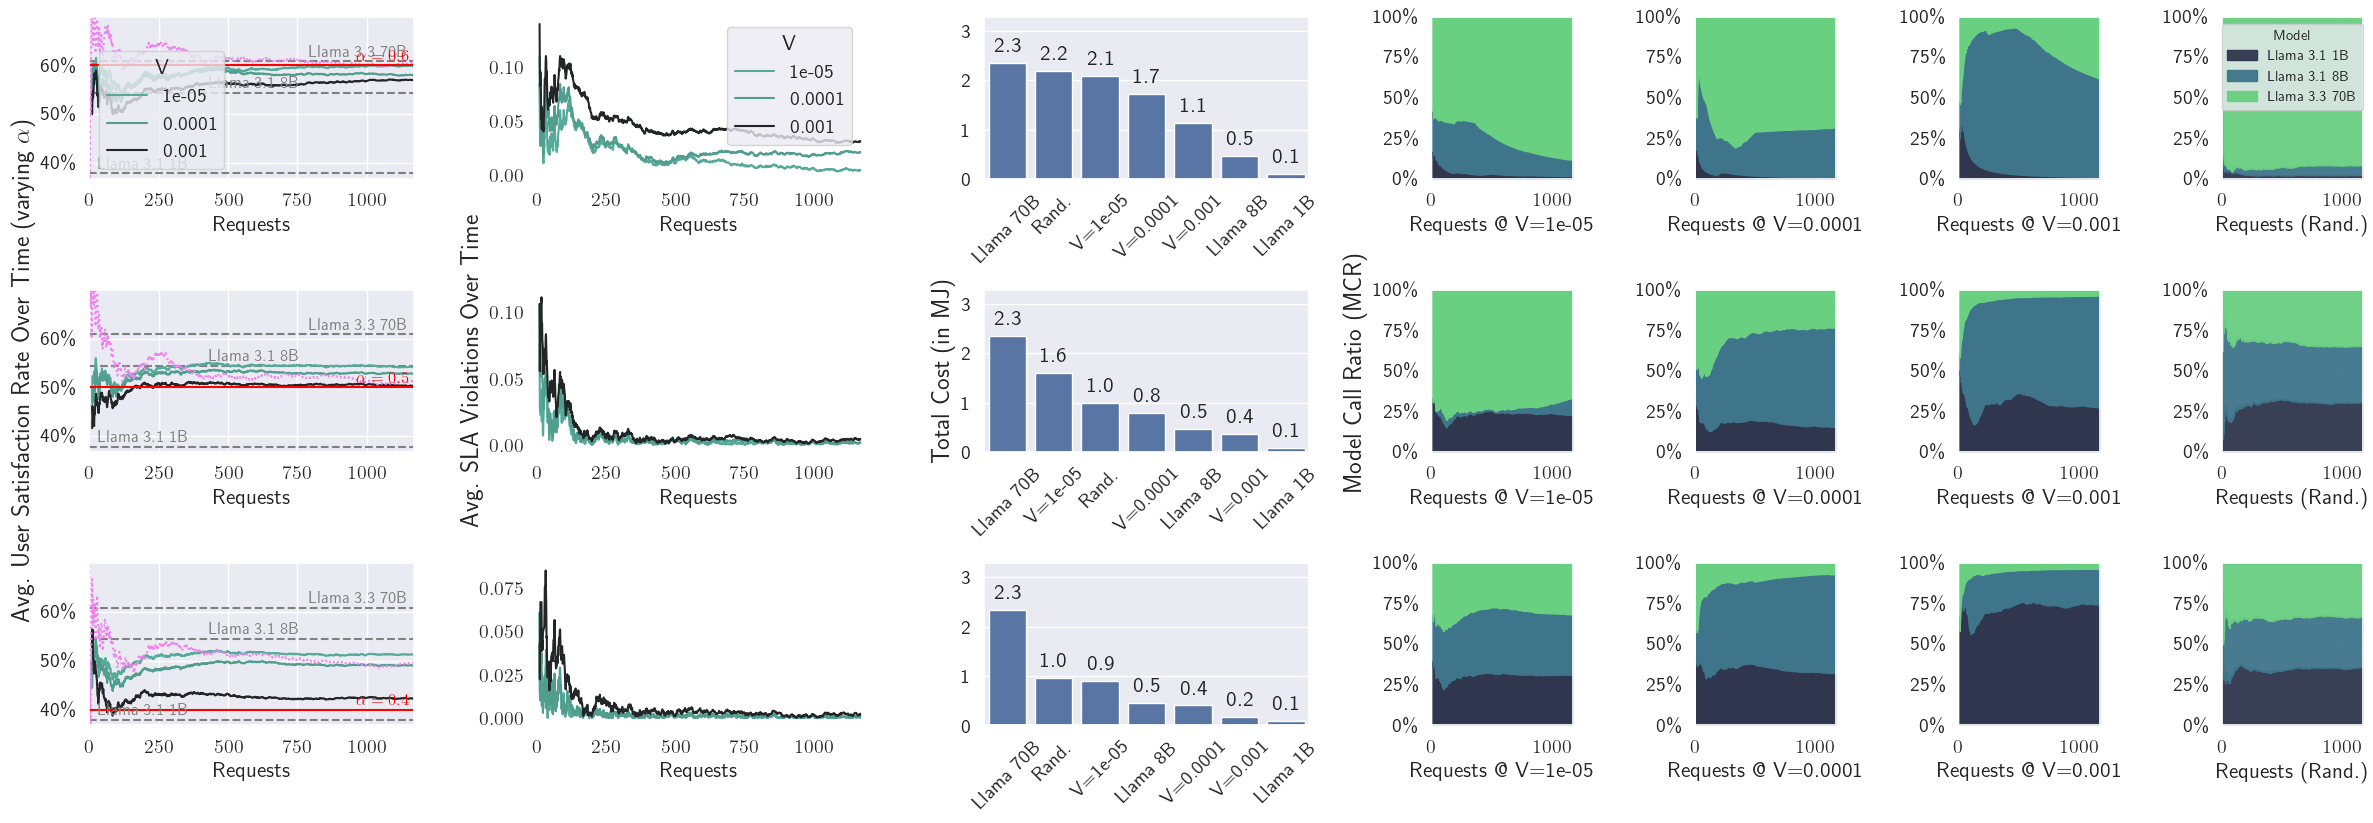

In [154]:
# Set the style for all plots
sns.set_style("white")
sns.set_palette(palette="dark:#5A9_r")
sns.set(font_scale=1.3)

# Create a figure and a grid of subplots: 4 rows, 10 columns
fig, axes = plt.subplots(nrows=3, ncols=7, figsize=(24, 8.5), gridspec_kw={'width_ratios': [2.3, 2.3, 2.3, 1, 1, 1, 1]})

# # Flatten the 2D array of axes for easier iteration
# axes = axes.flatten()

name = "arc_challenge"
subset = run_df.loc[(run_df["benchmark_name"] == name) & (run_df["c"] == 0.1) & (run_df["V"].isin(v_values_per_benchmark[name])) & (run_df["_step"] > 10)]

iterator = 0
for alpha in subset["alpha"].unique().tolist():
	v_values = subset["V"].unique().tolist()
	c_values = subset["c"].unique().tolist()

	# alpha = target_alpha_per_benchmark[name]

	# Accuracy Plot
	raw_inference_accuracies_per_model = infer_df[["benchmark_name", "label_small", "label_medium", "label_large"]].groupby("benchmark_name").mean().loc[name]

	axes[iterator][0].text(s="Llama 3.1 1B", x=subset["_step"].min() + 20, y=raw_inference_accuracies_per_model["label_small"] + 0.01, color='gray', fontsize=12, ha="left")
	axes[iterator][0].text(s="Llama 3.1 8B", x=(subset["_step"].min() + 1/2 * subset["_step"].max()), y=raw_inference_accuracies_per_model["label_medium"] + 0.01, color='gray', fontsize=12, ha="center")
	axes[iterator][0].text(s="Llama 3.3 70B", x=subset["_step"].max() - 20, y=raw_inference_accuracies_per_model["label_large"] + 0.01, color='gray', fontsize=12, ha="right")
	axes[iterator][0].axhline(y=raw_inference_accuracies_per_model["label_small"], color='gray', linestyle='--')
	axes[iterator][0].axhline(y=raw_inference_accuracies_per_model["label_medium"], color='gray', linestyle='--')
	axes[iterator][0].axhline(y=raw_inference_accuracies_per_model["label_large"], color='gray', linestyle='--')

	sns.lineplot(
	    data=subset.loc[(subset["alpha"] == alpha)],
	    x="_step",
	    y="avg_accuracy",
	    hue="V",
		errorbar=None,
		ax=axes[iterator][0],
		legend=True if iterator == 0 else False,
		palette="dark:#5A9_r",
	)

	axes[iterator][0].plot(
		baseline_df.loc[(baseline_df["benchmark_name"] == name) & (baseline_df["alpha"] == alpha), "_step"],
		baseline_df.loc[(baseline_df["benchmark_name"] == name) & (baseline_df["alpha"] == alpha),"avg_accuracy"],
		color="violet", linestyle="dotted", label="Rand."
	)

	# if iterator == 0:
	# 	axes[iterator][0].legend(ncols=4, loc='upper center', bbox_to_anchor=(0.5, 1.55), fontsize=12, title_fontsize=12, title="V", labelspacing =0.1)

	axes[iterator][0].axhline(y=alpha, color='red', linestyle='-', label="alpha")
	axes[iterator][0].text(s=r"$ \alpha = {alpha_val} $ ".format(alpha_val=alpha), x=subset["_step"].max() - 20, y=alpha + 0.01, color='red', fontsize=12, ha="right")

	axes[iterator][0].set(ylim=[0.97 * raw_inference_accuracies_per_model["label_small"], 1.15 * raw_inference_accuracies_per_model["label_large"]])
	axes[iterator][0].yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))

	# Q Plot for SLA violations
	subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]

	sns.lineplot(
	    data=subset.loc[(subset["alpha"] == alpha)],
	    x="_step",
	    y="sla_violations",
	    hue="V",
		errorbar=None,
		ax=axes[iterator][1],
		legend=True if iterator == 0 else False,
		palette="dark:#5A9_r",

	)
	axes[iterator][1].set_facecolor('white')

	# if iterator == 0:
	# 	axes[iterator][1].legend(ncols=3, loc='upper center', bbox_to_anchor=(0.5, 1.55), fontsize=12, title_fontsize=12, title="V", labelspacing =0.1)

	# Energy consumption plot
	random_baseline_energy = baseline_df.loc[baseline_df["alpha"] == alpha, ["benchmark_name", "mess_plus/energy"]].groupby("benchmark_name").sum().loc[name].to_frame()
	random_baseline_energy["V"] = "Rand."
	random_baseline_energy["mess_plus/energy"] = random_baseline_energy[name]
	random_baseline_energy.reset_index(inplace=True)

	raw_inference_energy_data = infer_df[["benchmark_name", "energy_consumption_large", "energy_consumption_medium", "energy_consumption_small"]].groupby("benchmark_name").sum().loc[name].to_frame()
	raw_inference_energy_data["V"] = raw_inference_energy_data.index
	raw_inference_energy_data["mess_plus/energy"] = raw_inference_energy_data[name]
	raw_inference_energy_data.rename({name: "mess_plus/energy"}, inplace=True)
	raw_inference_energy_data.reset_index(inplace=True)

	raw_inference_energy_data["V"] = raw_inference_energy_data["V"].replace({"energy_consumption_large": "Llama 70B", "energy_consumption_medium": "Llama 8B", "energy_consumption_small": "Llama 1B"}, inplace=False)

	raw_inference_energy_data.drop([name, "index"], inplace=True, axis=1)

	energy_data = subset.loc[(subset["alpha"] == alpha)].groupby(["_step", "V"]).agg({"mess_plus/energy": "mean"}).groupby("V")["mess_plus/energy"].sum().reset_index()

	energy_data["V"] = energy_data["V"].apply(lambda sample: f"V={sample}")

	energy_data = pd.concat([random_baseline_energy, raw_inference_energy_data, energy_data], ignore_index=True)
	energy_data.reset_index(inplace=True)
	energy_data = energy_data.sort_values(by=["mess_plus/energy"], ascending=False)

	sns.barplot(
	    data=energy_data,
	    x="V",
	    y="mess_plus/energy",
		ax=axes[iterator][2],
		errorbar=("ci", 0.95)
	)

	add_value_labels(axes[iterator][2])
	axes[iterator][2].yaxis.set_major_formatter(plt.FuncFormatter(fmt_to_megajoules))
	axes[iterator][2].set(ylim=[0, 1.4 * energy_data["mess_plus/energy"].max()])
	axes[iterator][2].tick_params(axis='x', labelrotation=45)

	# Classifier training loss plot
	# sns.lineplot(
	#     data=subset.loc[(subset["alpha"] == alpha)],
	#     x="_step",
	#     y="classifier/train_loss",
	#     hue="V",
	# 	errorbar=None,
	# 	ax=axes[3][iterator],
	# 	legend=False,
	# )

	# Stackplot for Model Call Ratio
	v_values_per_benchmark[name] = sorted(v_values_per_benchmark[name], reverse=False)
	# v_values_per_benchmark[name].reverse()
	for jdx, V in enumerate(v_values_per_benchmark[name]):

		stack_df = subset.loc[
			(run_df["benchmark_name"] == name) &
			(run_df["V"] == V) &
			(subset["alpha"] == alpha),
			["_step", "V", "models/small_chosen", "models/medium_chosen", "models/large_chosen"]
		].groupby(["_step"]).mean().reset_index()

		x = stack_df["_step"]
		y = stack_df[["models/small_chosen", "models/medium_chosen", "models/large_chosen"]]
		y_stack = np.cumsum(y, axis=1)

		axes[iterator][3 + jdx].fill_between(x, 0, y_stack.iloc[:, 0], color="#2f364d", alpha=1.0)
		axes[iterator][3 + jdx].fill_between(x, y_stack.iloc[:, 0], y_stack.iloc[:, 1], color="#3f758a", alpha=1.0)
		axes[iterator][3 + jdx].fill_between(x, y_stack.iloc[:, 1], y_stack.iloc[:, 2], color="#69cf81", alpha=1.0)
		axes[iterator][3 + jdx].set(xlabel=f"Requests @ V={V}", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()], ylim=[0, 1])
		axes[iterator][3 + jdx].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
		axes[iterator][3 + jdx].set(xlim=[0, stack_df["_step"].max()])

		# if jdx > 0:
		# 	axes[iterator][3 + jdx].get_yaxis().set_visible(False)

	# Add area plot for random baseline with constraint.
	baseline_stack_df = baseline_df.loc[
			(baseline_df["benchmark_name"] == name) &
			(baseline_df["alpha"] == alpha),
			["_step", "models/small_chosen", "models/medium_chosen", "models/large_chosen"]
		].groupby(["_step"]).mean().reset_index()

	x_base = baseline_stack_df["_step"]
	y_base = baseline_stack_df[["models/small_chosen", "models/medium_chosen", "models/large_chosen"]]
	y_stack_base = np.cumsum(y_base, axis=1)

	axes[iterator][6].fill_between(x_base, 0, y_stack_base.iloc[:, 0], color="#2f364d", alpha=0.95)
	axes[iterator][6].fill_between(x_base, y_stack_base.iloc[:, 0], y_stack_base.iloc[:, 1], color="#3f758a", alpha=0.95)
	axes[iterator][6].fill_between(x_base, y_stack_base.iloc[:, 1], y_stack_base.iloc[:, 2], color="#69cf81", alpha=0.95)
	axes[iterator][6].set(xlabel=f"Requests (Rand.)", xlim=[0, baseline_stack_df["_step"].max()], ylim=[0, 1])
	axes[iterator][6].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
	axes[iterator][6].set(xlim=[0, baseline_stack_df["_step"].max()])
	# axes[iterator][6].get_yaxis().set_visible(False)

	if iterator == 0:
		axes[iterator][6].legend(["Llama 3.1 1B", "Llama 3.1 8B", "Llama 3.3 70B"], ncols=1, loc='upper center', fontsize=10.5, title_fontsize=10.5, title="Model")


	axes[iterator][0].set(xlabel="Requests", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()])
	axes[iterator][1].set(xlabel="Requests", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()])
	axes[iterator][2].set(xlabel="")
	# axes[3][iterator].set(xlabel="Request", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()])

	axes[iterator][0].set(ylabel=None)
	axes[iterator][1].set(ylabel=None)
	axes[iterator][2].set(ylabel=None)
		# axes[3][iterator].set(ylabel=None)

	for ax, col in zip(axes[iterator], [r"Avg. User Satisfaction Rate Over Time (varying $\alpha$)".format(alpha_val=alpha), "Avg. SLA Violations Over Time", "Total Cost (in MJ)", "Model Call Ratio (MCR)", "", ""]):

		if iterator == 1:
			ax.set_ylabel(col, rotation=90, size=18)

	iterator += 1

fig.tight_layout()
write_figure_to_disk(plt, file_name=f"{name}_all_alpha", chapter_name="evaluations")


In [8]:
print(infer_df.columns)
print(infer_df.groupby("benchmark_name")["energy_consumption_large"].mean())
print(infer_df.groupby("benchmark_name")["energy_consumption_medium"].mean())
print(infer_df.groupby("benchmark_name")["energy_consumption_small"].mean())

Index(['index', 'input_text', 'benchmark_name', 'label_small',
       'acc_norm_small', 'energy_consumption_small', 'inference_time_small',
       'label_medium', 'acc_norm_medium', 'energy_consumption_medium',
       'inference_time_medium', 'label_large', 'acc_norm_large',
       'energy_consumption_large', 'inference_time_large', 'idx_original',
       'acc_small', 'acc_medium', 'acc_large'],
      dtype='object')
benchmark_name
arc_challenge    2002.590887
arc_easy         2021.235757
boolq            1040.777086
logiqa           2103.261339
piqa             1000.305741
sciq             2230.167317
social_iqa       1534.331063
winogrande       1018.422575
Name: energy_consumption_large, dtype: float64
benchmark_name
arc_challenge    393.661659
arc_easy         389.570495
boolq            130.735684
logiqa           414.384779
piqa             198.286026
sciq             444.054969
social_iqa       301.791954
winogrande       200.450200
Name: energy_consumption_medium, dtype: float6

/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2909120980.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2909120980.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alp

Plot saved.


/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2909120980.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2909120980.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alp

Plot saved.


/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2909120980.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2909120980.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alp

Plot saved.


/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2909120980.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2909120980.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alp

Plot saved.


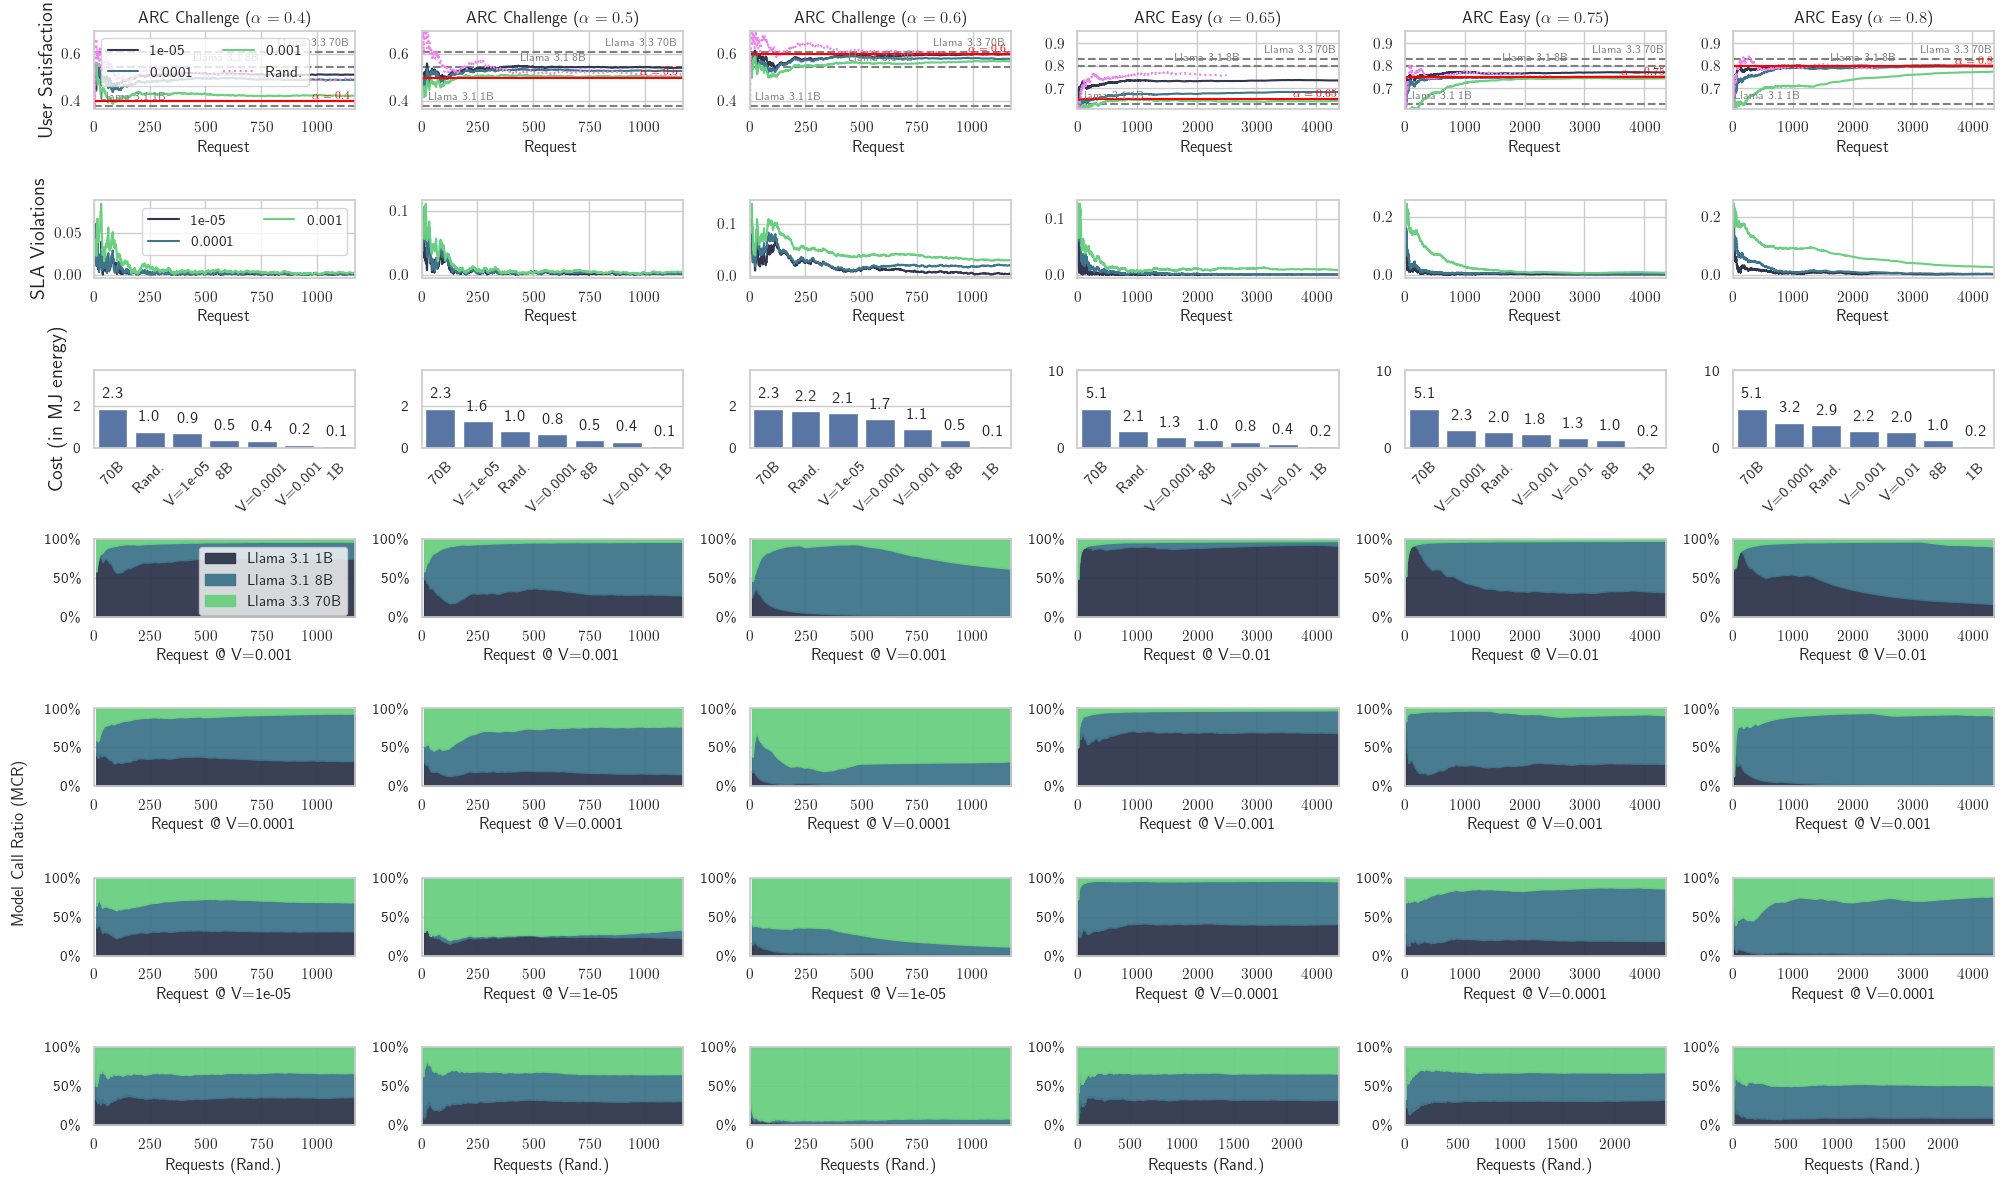

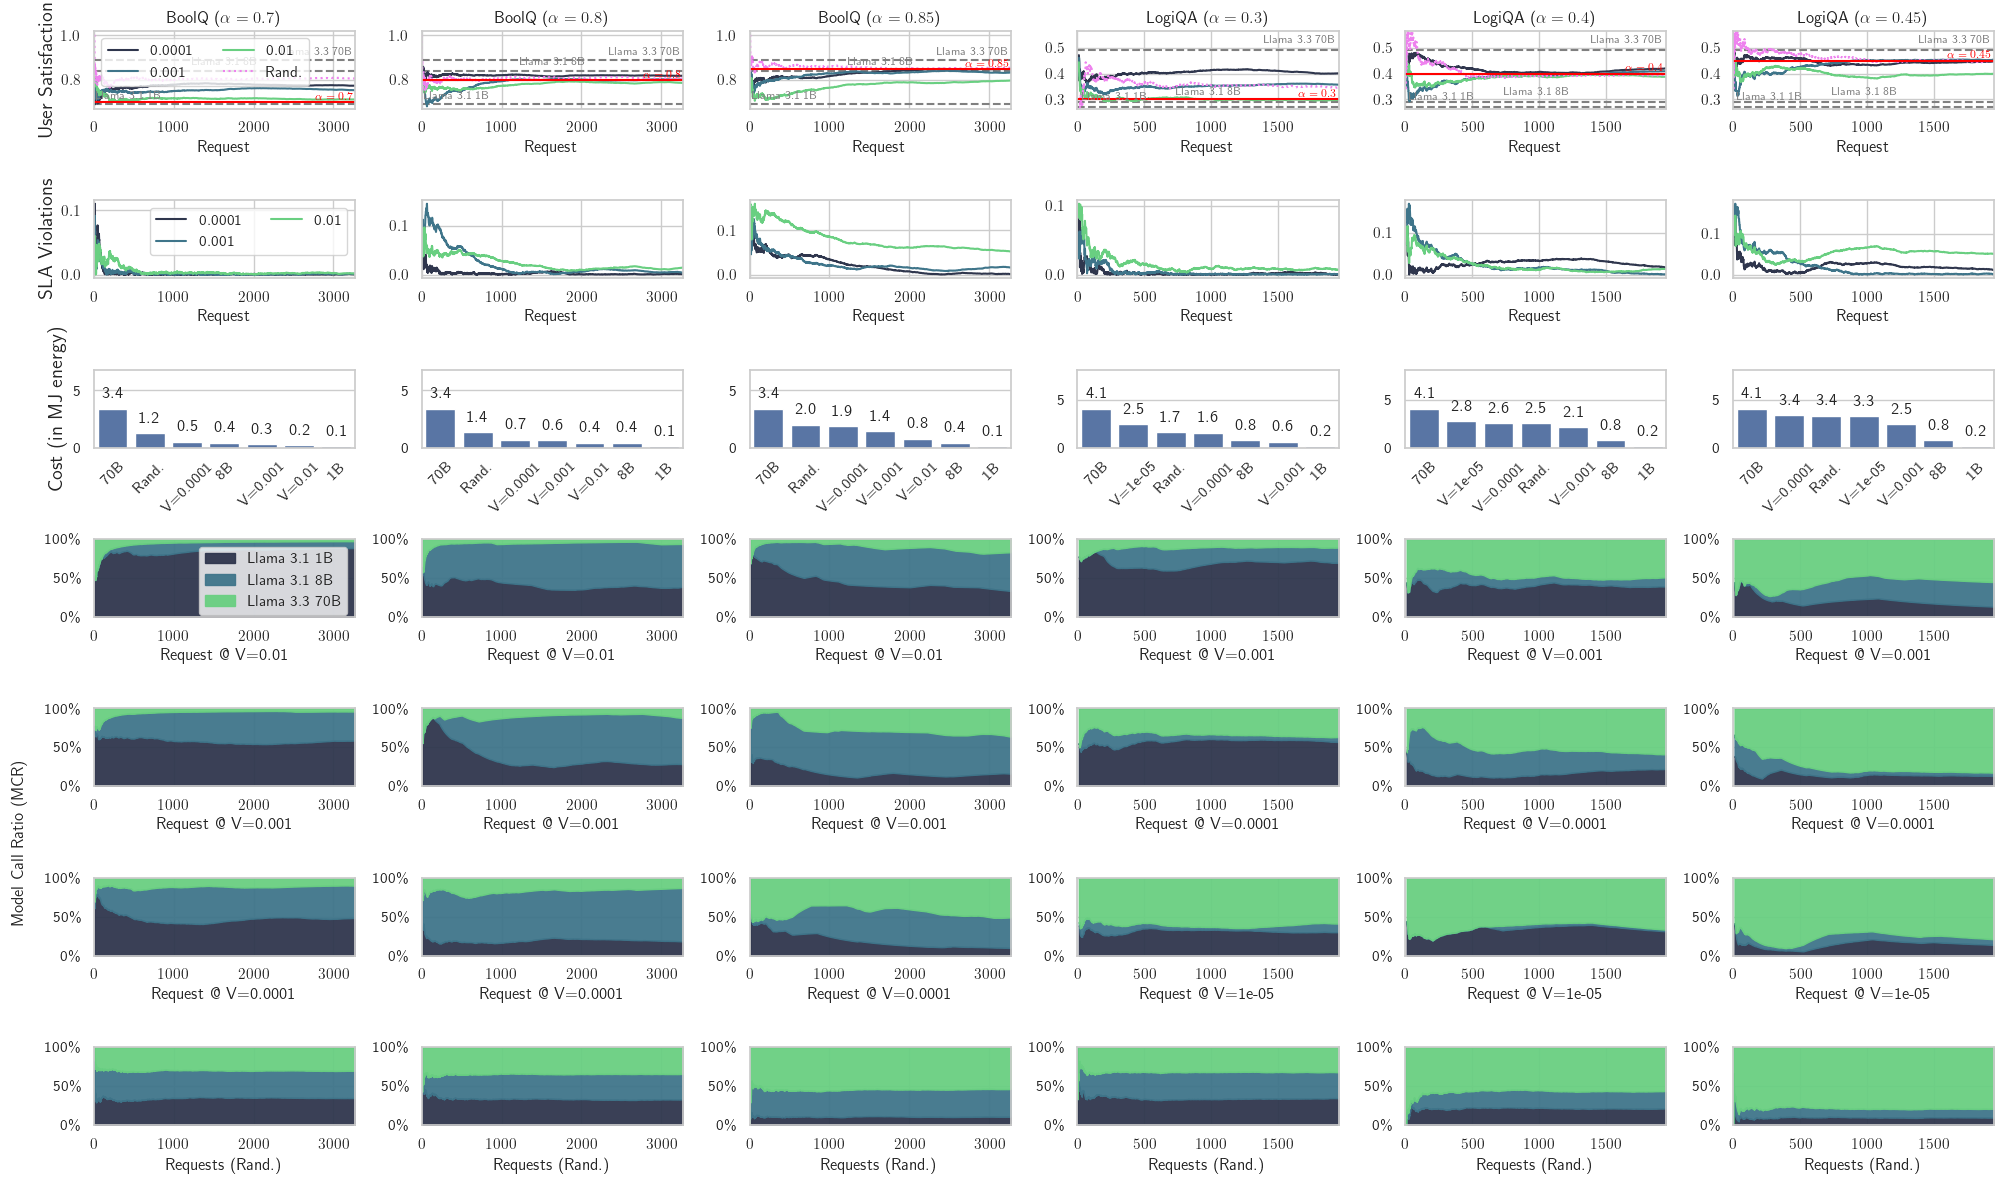

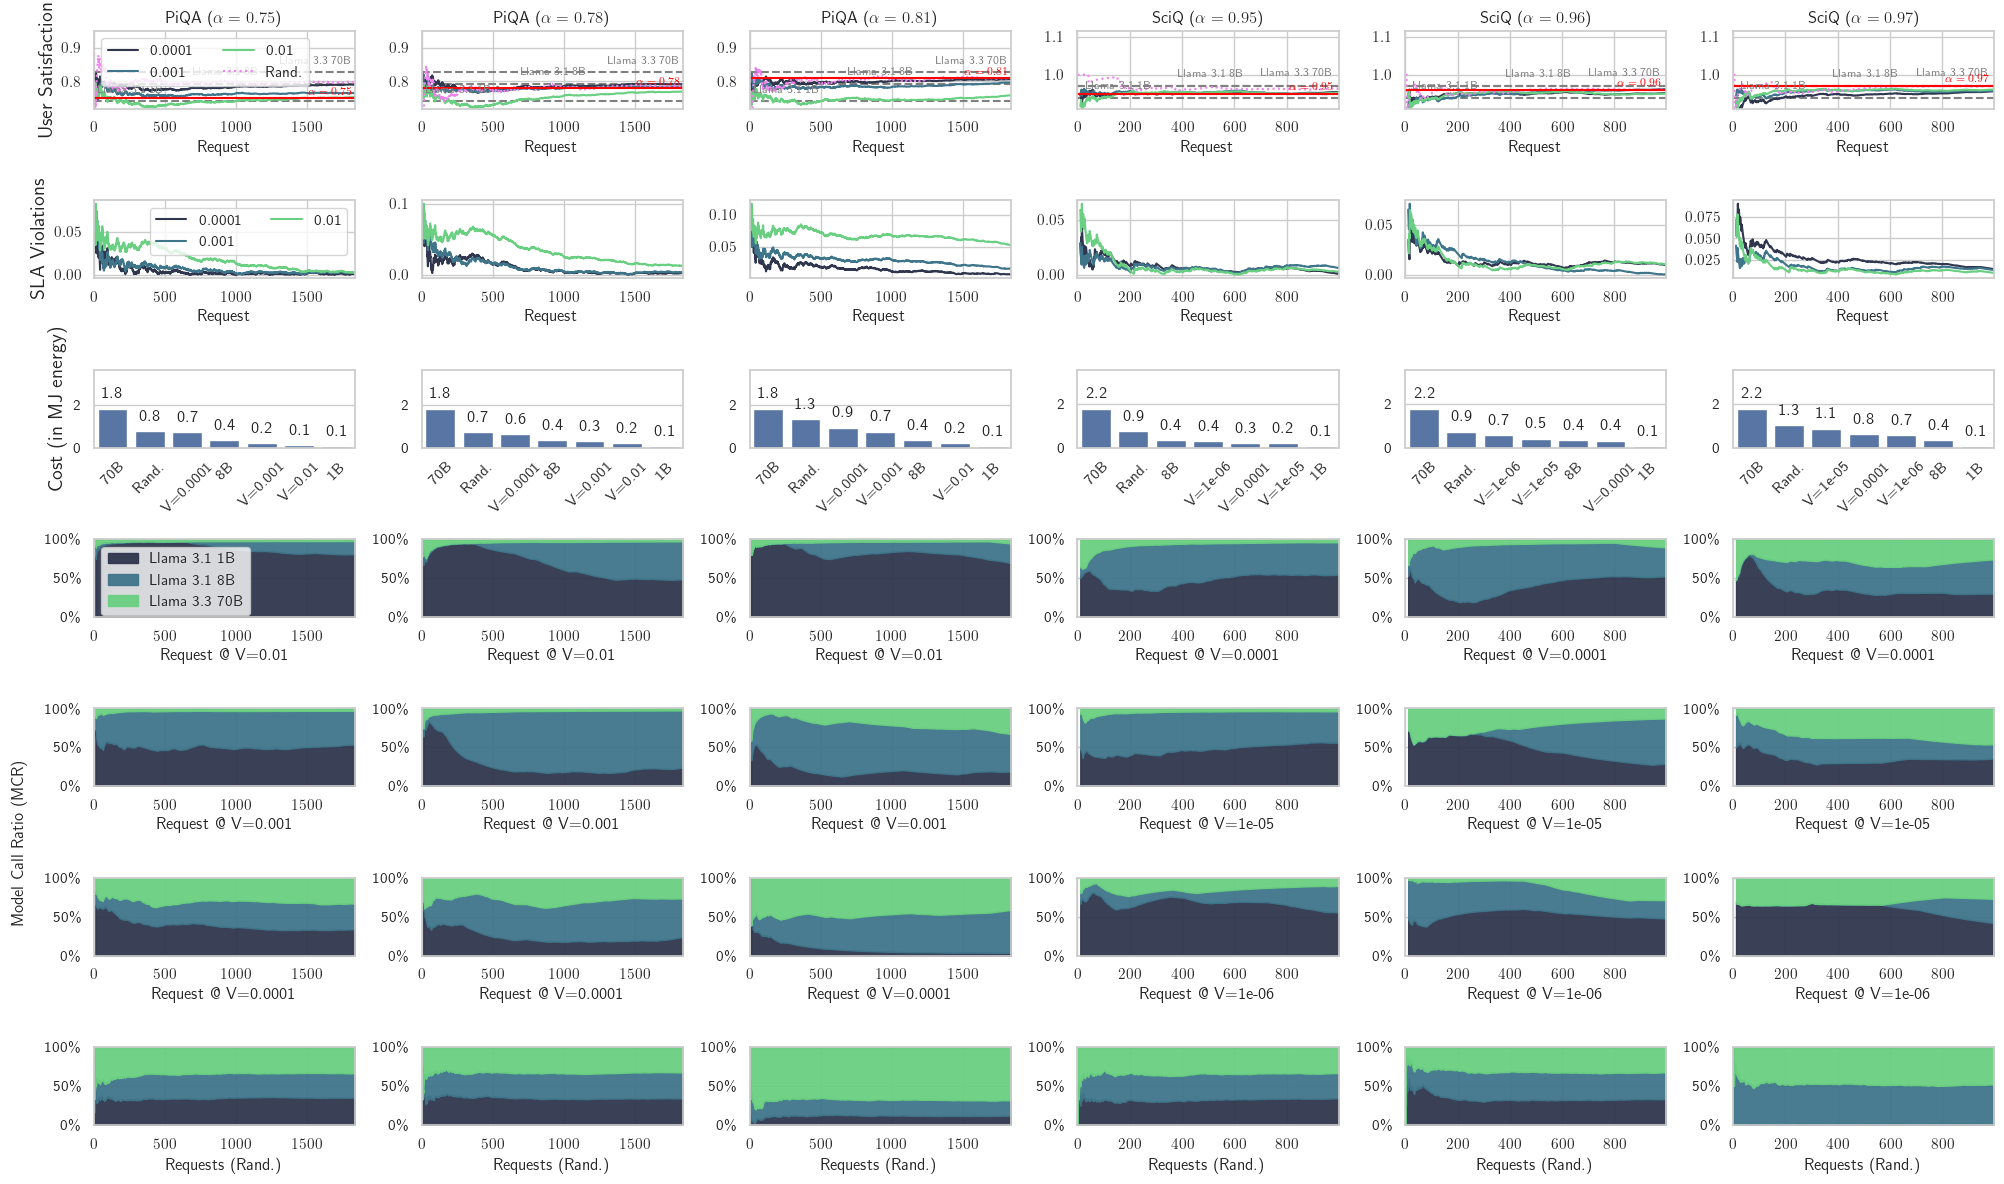

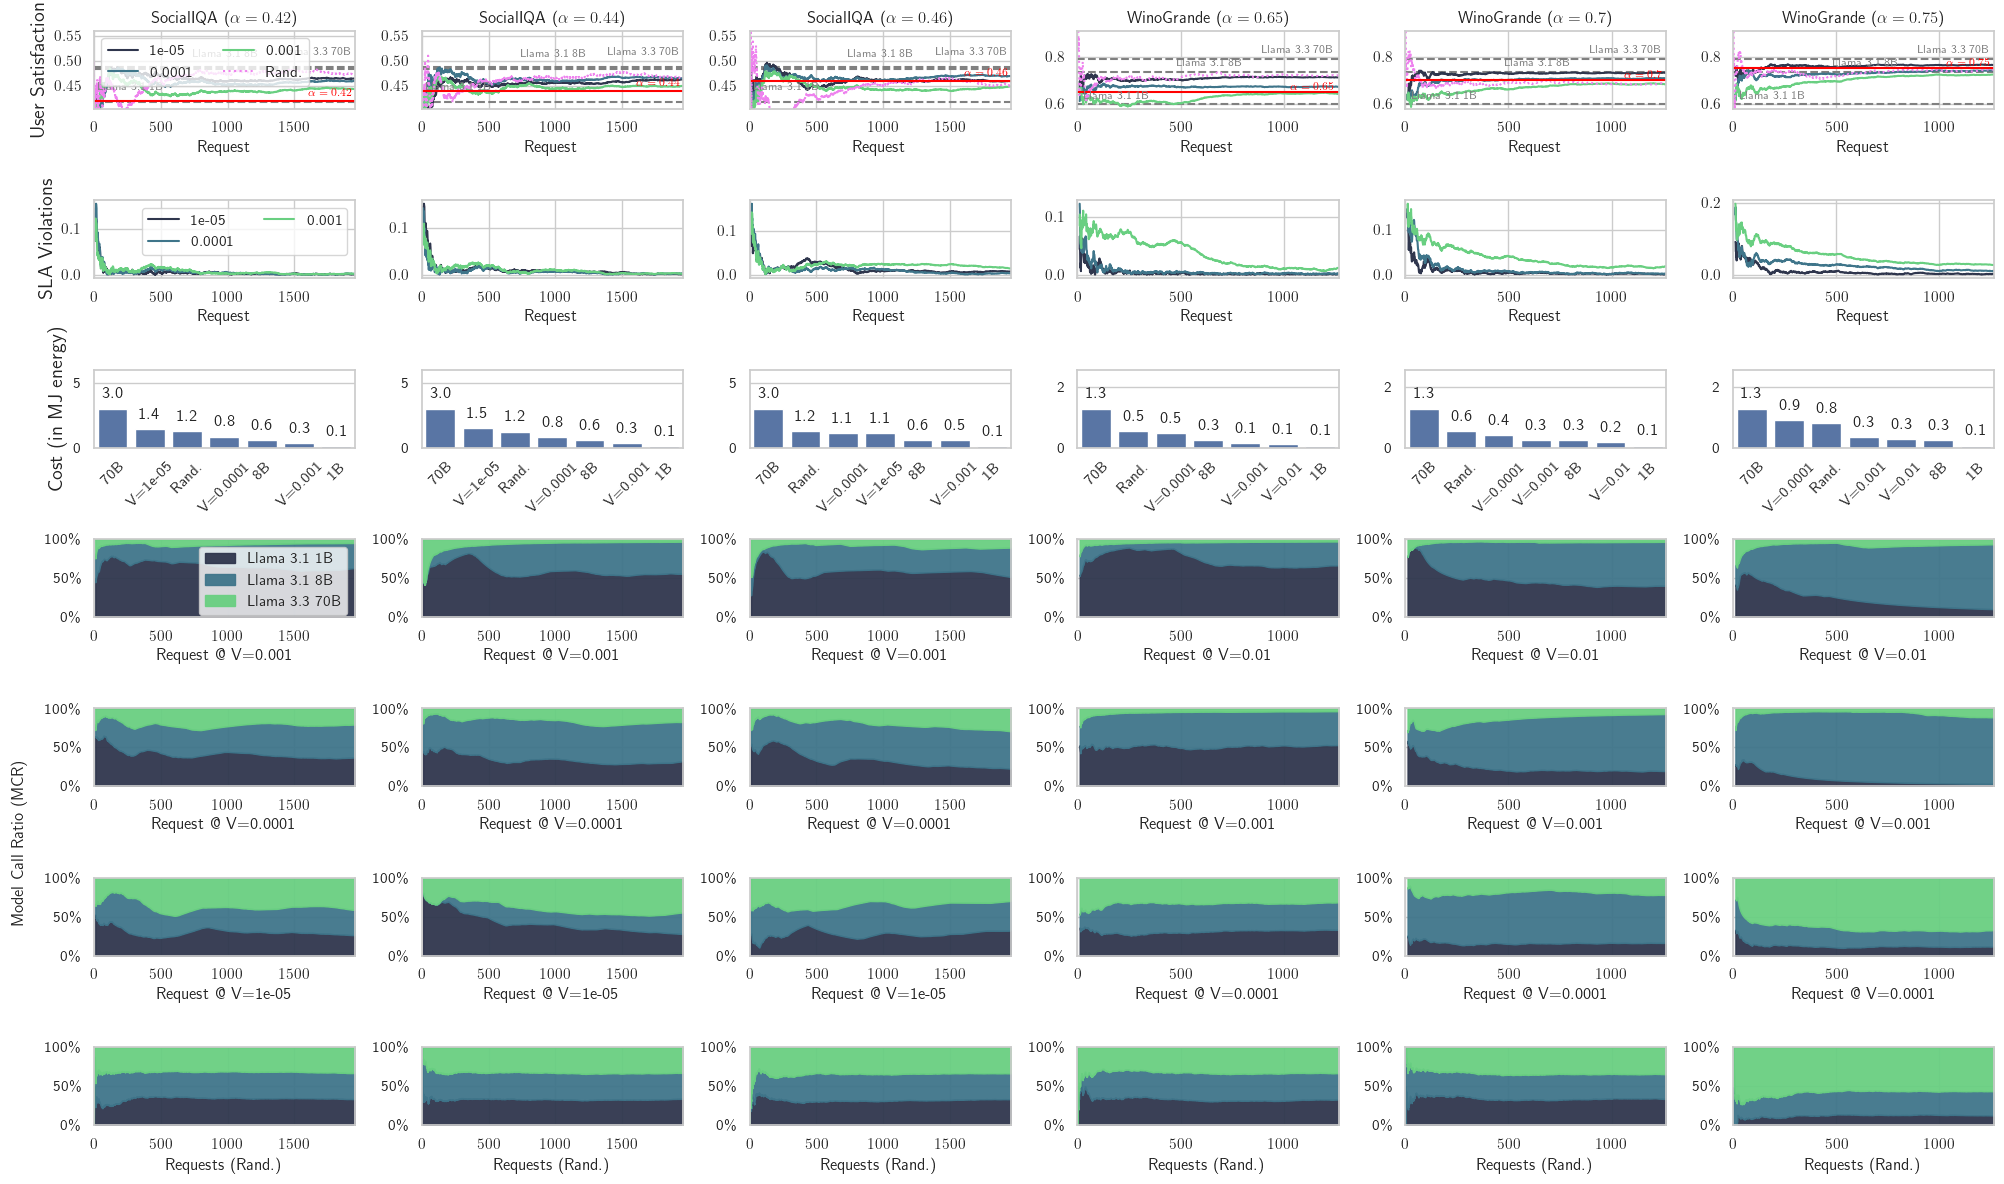

In [151]:
# Plot generator
v_values_per_benchmark = {
    "arc_challenge": [0.001, 0.0001, 0.00001],
    "arc_easy": [0.01, 0.001, 0.0001],
    "boolq": [0.01, 0.001, 0.0001],
    # "lambada_standard": [0.01, 0.001, 0.0001],
    "logiqa": [0.001, 0.0001, 0.00001],
    # "logiqa2": [0.01, 0.001, 0.0001],
    "piqa": [0.01, 0.001, 0.0001],
    "sciq": [0.0001, 0.00001, 0.000001],
    "social_iqa": [0.001, 0.0001, 0.00001],
    "winogrande": [0.01, 0.001, 0.0001],
}

BENCHMARK_NAME_DICT = {
    "arc_challenge": "ARC Challenge",
    "arc_easy": "ARC Easy",
    "boolq": "BoolQ",
    # "lambada_standard": "Lambada",
    "logiqa": "LogiQA",
    # "logiqa2": "LogiQA2",
    "piqa": "PiQA",
    "sciq": "SciQ",
    "social_iqa": "SocialIQA",
    "winogrande": "WinoGrande",
}

# Create a list of all benchmark-alpha combinations
benchmark_alpha_combinations = []
for name in v_values_per_benchmark.keys():
    config_path = Path(f"{NOTEBOOK_PATH.parent}/config/online/{name}.yaml")
    with config_path.open("r") as f:
        import yaml
        CONFIG = yaml.safe_load(f)

    algorithm_config = CONFIG["algorithm"]
    for alpha in algorithm_config["alpha_values"]:
        benchmark_alpha_combinations.append((name, alpha))

# Initialize plotting variables
plot_num = 0
col_count = 0

# Iterate through all benchmark-alpha combinations
for combo_idx, (name, alpha) in enumerate(benchmark_alpha_combinations):

    # Create new figure every 6 columns
    if col_count == 0:
        sns.set(style="whitegrid")
        fig, axes = plt.subplots(nrows=7, ncols=6, figsize=(20, 12))
        plot_num += 1

    # Get current column index
    col_idx = col_count

    # Skip if this benchmark doesn't have V values configured
    if name not in v_values_per_benchmark.keys():
        continue

    # Filter data for current benchmark and alpha
    subset = run_df.loc[(run_df["benchmark_name"] == name) &
                       (run_df["c"] == 0.1) &
                       (run_df["V"].isin(v_values_per_benchmark[name])) &
                       (run_df["_step"] > 10) &
                       (run_df["alpha"] == alpha)]

    v_values = subset["V"].unique().tolist()

    # Accuracy Plot
    raw_inference_accuracies_per_model = infer_df[["benchmark_name", "label_small", "label_medium", "label_large"]].groupby("benchmark_name").mean().loc[name]

    axes[0][col_idx].text(s="Llama 3.1 1B", x=subset["_step"].min() + 20, y=raw_inference_accuracies_per_model["label_small"] + 0.025, color='gray', fontsize=8, ha="left")
    axes[0][col_idx].text(s="Llama 3.1 8B", x=(subset["_step"].min() + 1/2 * subset["_step"].max()), y=raw_inference_accuracies_per_model["label_medium"] + 0.025, color='gray', fontsize=8, ha="center")
    axes[0][col_idx].text(s="Llama 3.3 70B", x=subset["_step"].max() - 20, y=raw_inference_accuracies_per_model["label_large"] + 0.025, color='gray', fontsize=8, ha="right")
    axes[0][col_idx].axhline(y=raw_inference_accuracies_per_model["label_small"], color='gray', linestyle='--')
    axes[0][col_idx].axhline(y=raw_inference_accuracies_per_model["label_medium"], color='gray', linestyle='--')
    axes[0][col_idx].axhline(y=raw_inference_accuracies_per_model["label_large"], color='gray', linestyle='--')

    sns.lineplot(
        data=subset.loc[(subset["alpha"] == alpha)],
        x="_step",
        y="avg_accuracy",
        hue="V",
        errorbar=None,
        ax=axes[0][col_idx],
        legend=True if col_idx == 0 else False,
	    palette=["#2f364d", "#3f758a", "#69cf81"]
    )

    axes[0][col_idx].plot(
		baseline_df.loc[(baseline_df["benchmark_name"] == name) & (baseline_df["alpha"] == alpha), "_step"],
		baseline_df.loc[(baseline_df["benchmark_name"] == name) & (baseline_df["alpha"] == alpha),"avg_accuracy"],
		color="violet", linestyle="dotted", label="Rand."
	)

    axes[0][col_idx].axhline(y=alpha, color='red', linestyle='-')
    axes[0][col_idx].text(s=r"$ \alpha = {alpha_val} $ ".format(alpha_val=alpha), x=subset["_step"].max() - 20, y=alpha + 0.01, color='red', fontsize=8, ha="right")

    axes[0][col_idx].set(ylim=[0.97 * raw_inference_accuracies_per_model["label_small"], 1.15 * raw_inference_accuracies_per_model["label_large"]])

    if col_idx == 0:
        axes[0][col_idx].legend(ncols=2)

    # Q Plot for SLA violations
    subset.loc[(subset["alpha"] == alpha), "sla_violations"] = subset.loc[(subset["alpha"] == alpha), "mess_plus/q_length"] / subset.loc[(subset["alpha"] == alpha), "_step"]
    sns.lineplot(
        data=subset.loc[(subset["alpha"] == alpha)],
        x="_step",
        y="sla_violations",
        hue="V",
        errorbar=None,
        ax=axes[1][col_idx],
        legend=True if col_idx == 0 else False,
	    palette=["#2f364d", "#3f758a", "#69cf81"]
    )

    if col_idx == 0:
        axes[1][col_idx].legend(ncols=2)

    # Energy consumption plot
    random_baseline_energy = baseline_df.loc[baseline_df["alpha"] == alpha, ["benchmark_name", "mess_plus/energy"]].groupby("benchmark_name").sum().loc[name].to_frame()
    random_baseline_energy["V"] = "Rand."
    random_baseline_energy["mess_plus/energy"] = random_baseline_energy[name]
    random_baseline_energy.reset_index(inplace=True)

    raw_inference_energy_data = infer_df[["benchmark_name", "energy_consumption_large", "energy_consumption_medium", "energy_consumption_small"]].groupby("benchmark_name").sum().loc[name].to_frame()
    raw_inference_energy_data["V"] = raw_inference_energy_data.index
    raw_inference_energy_data["mess_plus/energy"] = raw_inference_energy_data[name]
    raw_inference_energy_data.rename({name: "mess_plus/energy"}, inplace=True)
    raw_inference_energy_data.reset_index(inplace=True)

    raw_inference_energy_data["V"] = raw_inference_energy_data["V"].replace({"energy_consumption_large": "70B", "energy_consumption_medium": "8B", "energy_consumption_small": "1B"}, inplace=False)

    raw_inference_energy_data.drop([name, "index"], inplace=True, axis=1)
    energy_data = subset.loc[(subset["alpha"] == alpha)].groupby(["_step", "V"]).agg({"mess_plus/energy": "mean"}).groupby("V")["mess_plus/energy"].sum().reset_index()

    energy_data["V"] = energy_data["V"].apply(lambda sample: f"V={sample}")

    energy_data = pd.concat([random_baseline_energy, raw_inference_energy_data, energy_data], ignore_index=True)
    energy_data.reset_index(inplace=True)
    energy_data = energy_data.sort_values(by=["mess_plus/energy"], ascending=False)

    sns.barplot(
        data=energy_data,
        x="V",
        y="mess_plus/energy",
        ax=axes[2][col_idx],
        errorbar=("ci", 0.95),
    )

    add_value_labels(axes[2][col_idx])
    axes[2][col_idx].yaxis.set_major_formatter(plt.FuncFormatter(fmt_to_megajoules))
    axes[2][col_idx].set(ylim=[0, 2 * energy_data["mess_plus/energy"].max()])
    axes[2][col_idx].tick_params(axis='x', labelrotation=45)

    # Stackplot for Model Call Ratio
    for jdx, V in enumerate(v_values_per_benchmark[name]):

        stack_df = subset.loc[
            (run_df["benchmark_name"] == name) &
            (run_df["V"] == V) &
            (subset["alpha"] == alpha),
            ["_step", "models/small_chosen", "models/medium_chosen", "models/large_chosen"]
        ].groupby(["_step"]).mean().reset_index()

        x = stack_df["_step"]
        y = stack_df[["models/small_chosen", "models/medium_chosen", "models/large_chosen"]]
        y_stack = np.cumsum(y, axis=1)

        axes[3 + jdx][col_idx].fill_between(x, 0, y_stack.iloc[:, 0], color="#2f364d", alpha=0.95)
        axes[3 + jdx][col_idx].fill_between(x, y_stack.iloc[:, 0], y_stack.iloc[:, 1], color="#3f758a", alpha=0.95)
        axes[3 + jdx][col_idx].fill_between(x, y_stack.iloc[:, 1], y_stack.iloc[:, 2], color="#69cf81", alpha=0.95)
        axes[3 + jdx][col_idx].set(xlabel=f"Request @ V={V}", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()], ylim=[0, 1])
        axes[3 + jdx][col_idx].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

        if jdx == 0 and col_idx == 0:
            axes[3 + jdx][col_idx].legend(["Llama 3.1 1B", "Llama 3.1 8B", "Llama 3.3 70B"])

    # Add area plot for random baseline with constraint.
    baseline_stack_df = baseline_df.loc[
            (baseline_df["benchmark_name"] == name) &
            (baseline_df["alpha"] == alpha),
            ["_step", "models/small_chosen", "models/medium_chosen", "models/large_chosen"]
        ].groupby(["_step"]).mean().reset_index()

    x_base = baseline_stack_df["_step"]
    y_base = baseline_stack_df[["models/small_chosen", "models/medium_chosen", "models/large_chosen"]]
    y_stack_base = np.cumsum(y_base, axis=1)

    axes[6][col_idx].fill_between(x_base, 0, y_stack_base.iloc[:, 0], color="#2f364d", alpha=0.95)
    axes[6][col_idx].fill_between(x_base, y_stack_base.iloc[:, 0], y_stack_base.iloc[:, 1], color="#3f758a", alpha=0.95)
    axes[6][col_idx].fill_between(x_base, y_stack_base.iloc[:, 1], y_stack_base.iloc[:, 2], color="#69cf81", alpha=0.95)
    axes[6][col_idx].set(xlabel=f"Requests (Rand.)", xlim=[0, baseline_stack_df["_step"].max()], ylim=[0, 1])
    axes[6][col_idx].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    axes[6][col_idx].set(xlim=[0, baseline_stack_df["_step"].max()])

    # Set axis properties
    axes[0][col_idx].set(xlabel="Request", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()])
    axes[1][col_idx].set(xlabel="Request", xlim=[0, subset.loc[(subset["alpha"] == alpha), "_step"].max()])
    axes[2][col_idx].set(xlabel="")

    # Remove y-labels for columns after the first
    if col_idx > 0:
        axes[0][col_idx].set(ylabel=None)
        axes[1][col_idx].set(ylabel=None)
        axes[2][col_idx].set(ylabel=None)

    # Set title for each column
    axes[0][col_idx].set_title(r"{bm_name} ($\alpha = {alpha_val} $)".format(bm_name=BENCHMARK_NAME_DICT[name], alpha_val=alpha))

    # Increment column counter
    col_count += 1

    # Check if we need to save the current figure and start a new one
    if col_count == 6 or combo_idx == len(benchmark_alpha_combinations) - 1:
        # Add row labels
        for idx, (ax, row) in enumerate(zip(axes[:,0], ["User Satisfaction", "SLA Violations", "Cost (in MJ energy)", "", "", "", ""])):
            if idx == 5:
                fig.text(0.003, 0.225, "Model Call Ratio (MCR)", ha="center", rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])
            else:
                ax.set_ylabel(row, rotation=90, size='large')

        # Save the figure
        fig.tight_layout()
        write_figure_to_disk(plt, file_name=f"benchmark_performance_plot_{plot_num}", chapter_name="evaluations")

        # Reset column counter for next figure
        col_count = 0

In [39]:
def dataframe_to_latex_with_color(df, high_color='green!60', low_color='red!60'):
    """
    Convert a pandas DataFrame to a LaTeX table with color coding for accuracy columns.

    Parameters:
    df: pandas DataFrame (must have 'alpha' in the index or as a column)
    high_color: LaTeX color for values >= threshold
    low_color: LaTeX color for values < threshold
    """
    import pandas as pd

    # Create a copy to avoid modifying the original
    df_copy = df.copy()

    # Check if we have a MultiIndex with alpha
    alpha_from_index = False
    if isinstance(df_copy.index, pd.MultiIndex) and 'alpha' in df_copy.index.names:
        alpha_from_index = True
        # Reset index to get alpha as a regular column
        df_copy = df_copy.reset_index()

    # Round all numeric values to 2 decimal places
    df_rounded = df_copy.round(2)

    # Function to determine if a value should be colored
    def should_color(col_name):
        # Color if 'accuracy' is in the column name (case insensitive)
        return 'accuracy' in col_name.lower() or 'label' in col_name.lower()

    # Function to format a cell with color coding
    def format_cell(value, col_name, alpha):
        # Convert value to scalar if it's a Series
        if hasattr(value, 'item'):
            try:
                value = value.item()
            except ValueError:
                # If multiple values, take the first one
                value = value.iloc[0] if hasattr(value, 'iloc') else value

        # Ensure alpha is also a scalar
        if hasattr(alpha, 'item'):
            try:
                alpha = alpha.item()
            except ValueError:
                alpha = alpha.iloc[0] if hasattr(alpha, 'iloc') else alpha

        if should_color(col_name) and pd.notna(value):
            try:
                if float(value) >= float(alpha):
                    return f"\\cellcolor{{{high_color}}}{float(value):.2f}"
                else:
                    return f"\\cellcolor{{{low_color}}}{float(value):.2f}"
            except (ValueError, TypeError):
                # If value cannot be converted to float, return as is
                return str(value)
        else:
            if pd.notna(value):
                if isinstance(value, (int, float)):
                    return f"{float(value):.2f}"
                else:
                    return str(value)
            else:
                return "-"

    # Start building the LaTeX table
    latex_lines = []
    latex_lines.append("\\begin{table}[h!]")
    latex_lines.append("\\centering")

    # Calculate total columns (alpha + benchmark + data columns)
    # No index column, just alpha, benchmark, and data columns
    data_cols = len(df_copy.columns)
    if alpha_from_index:
        data_cols -= 2  # Remove benchmark and alpha from the count
    elif 'alpha' in df_copy.columns:
        data_cols -= 1  # Remove alpha from the count
    else:
        raise ValueError("Alpha must be either in the index or as a column for color coding")

    total_cols = data_cols + 2  # alpha + benchmark + data columns

    latex_lines.append("\\begin{tabular}{" + "c" * total_cols + "}")
    latex_lines.append("\\toprule")

    # Handle multi-level columns
    if isinstance(df.columns, pd.MultiIndex):
        # Get the number of levels
        n_levels = df.columns.nlevels

        # Create header rows for each level
        for level in range(n_levels):
            header_row = []
            if level == 0:
                header_row.append("\\multirow{" + str(n_levels) + "}{*}{Alpha}")
                header_row.append("\\multirow{" + str(n_levels) + "}{*}{Benchmark}")
            else:
                header_row.append("")
                header_row.append("")

            # Get labels for this level
            labels = []
            spans = []
            current_label = None
            current_span = 0

            for col in df.columns:
                # Skip index-related columns
                if alpha_from_index and isinstance(col, str) and col == 'alpha':
                    continue
                if alpha_from_index and isinstance(col, str) and col == df_copy.columns[0]:  # Skip benchmark column
                    continue

                label = str(col[level]) if isinstance(col, tuple) else str(col)
                if label != current_label:
                    if current_label is not None:
                        labels.append((current_label, current_span))
                    current_label = label
                    current_span = 1
                else:
                    current_span += 1

            # Don't forget the last group
            if current_label is not None:
                labels.append((current_label, current_span))

            # Add multicolumn headers
            for label, span in labels:
                # Add (MJ) to energy-related headers
                if any(energy_term in str(label).lower() for energy_term in ['energy', 'consumption', 'mess_plus']):
                    label = f"{label} (MJ)"

                if span > 1:
                    header_row.append(f"\\multicolumn{{{span}}}{{c}}{{{label}}}")
                else:
                    header_row.append(label)

            latex_lines.append(" & ".join(header_row) + " \\\\")

        # Add horizontal line between header levels
        latex_lines.append("\\cmidrule{3-" + str(total_cols) + "}")
    else:
        # Simple single-level header
        header_row = ["Alpha", "Benchmark"]

        for col in df_copy.columns:
            # Skip columns that are already handled
            if alpha_from_index and (col == 'alpha' or col == df_copy.columns[0]):
                continue
            elif not alpha_from_index and col == 'alpha':
                continue
            else:
                col_str = str(col)
                # Add (MJ) to energy-related headers
                if any(energy_term in col_str.lower() for energy_term in ['energy', 'consumption', 'mess_plus']):
                    col_str = f"{col_str} (MJ)"
                header_row.append(col_str)
        latex_lines.append(" & ".join(header_row) + " \\\\")

    latex_lines.append("\\midrule")

    # Add data rows
    for idx, row in df_rounded.iterrows():
        # Handle MultiIndex row (if it still exists, though we reset_index above)
        if isinstance(idx, tuple):
            benchmark_name = idx[0]
            alpha_value = idx[1] if len(idx) > 1 else None
        else:
            if alpha_from_index:
                # Properly extract the benchmark name value
                benchmark_value = row[df_copy.columns[0]]
                if hasattr(benchmark_value, 'item'):
                    try:
                        benchmark_name = benchmark_value.item()
                    except ValueError:
                        benchmark_name = benchmark_value.iloc[0] if hasattr(benchmark_value, 'iloc') else benchmark_value
                else:
                    benchmark_name = benchmark_value

                alpha_value = row['alpha']
            else:
                benchmark_name = str(idx)
                alpha_value = None

        # Get alpha value for display and color coding
        if alpha_value is None and 'alpha' in row:
            alpha_value = row['alpha']

        # Convert alpha_value to scalar if necessary
        if hasattr(alpha_value, 'item'):
            try:
                alpha_value = alpha_value.item()
            except ValueError:
                alpha_value = alpha_value.iloc[0] if hasattr(alpha_value, 'iloc') else alpha_value

        # If we still don't have alpha, raise an error
        if alpha_value is None:
            raise ValueError("Alpha must be either in the index or as a column for color coding")

        # Format the row - Alpha first, then Benchmark
        # Make sure benchmark_name is a string
        benchmark_name_str = str(benchmark_name)
        row_data = [f"{float(alpha_value):.2f}", benchmark_name_str]

        for col_name, value in row.items():
            # Skip columns we've already handled
            if alpha_from_index and (col_name == 'alpha' or col_name == df_copy.columns[0]):
                continue
            elif not alpha_from_index and col_name == 'alpha':
                continue

            # Get the actual column name for color checking
            if isinstance(df.columns, pd.MultiIndex):
                actual_col_name = " ".join(str(c) for c in col_name)
            else:
                actual_col_name = str(col_name)

            formatted_value = format_cell(value, actual_col_name, alpha_value)
            row_data.append(formatted_value)

        latex_lines.append(" & ".join(row_data) + " \\\\")

    latex_lines.append("\\bottomrule")
    latex_lines.append("\\end{tabular}")

    # Add caption and label
    latex_lines.append("\\caption{Comparison of Model Performance}")
    latex_lines.append("\\label{tab:model_comparison}")
    latex_lines.append("\\end{table}")

    # Add required packages in comments
    packages = [
        "% Required LaTeX packages:",
        "% \\usepackage{booktabs}",
        "% \\usepackage{multirow}",
        "% \\usepackage{xcolor}",
        "% \\usepackage{colortbl}",
        ""
    ]

    return "\n".join(packages + latex_lines)

In [58]:
# Overview table
pvt_baseline = baseline_df.pivot_table(index=["benchmark_name", "alpha"], values=["avg_accuracy", "mess_plus/energy"], aggfunc={"avg_accuracy": ["mean"], "mess_plus/energy": ["sum"]})

pvt_base_model = infer_df[["benchmark_name", "energy_consumption_large", "energy_consumption_medium", "energy_consumption_small", "label_small", "label_medium", "label_large"]].pivot_table(index=["benchmark_name"], values=["energy_consumption_large", "energy_consumption_medium", "energy_consumption_small", "label_small", "label_medium", "label_large"], aggfunc={"energy_consumption_large": ["sum"], "energy_consumption_medium": ["sum"], "energy_consumption_small": ["sum"], "label_small": ["mean"], "label_medium": ["mean"], "label_large": ["mean"]})

pvt_mess_plus_pre = run_df.groupby(['benchmark_name', 'alpha', 'V', "_step"]).agg({
    'avg_accuracy': 'mean',
    'mess_plus/energy': 'mean'  # Average across seeds first
}).reset_index()

pvt_mess_plus = pvt_mess_plus_pre.loc[pvt_mess_plus_pre["V"].isin([0.00001, 0.0001, 0.001]), ["benchmark_name", "alpha", "V", "avg_accuracy", "mess_plus/energy"]].pivot_table(index=["benchmark_name", "alpha"], columns=["V"], values=["avg_accuracy", "mess_plus/energy"], aggfunc={"avg_accuracy": ["mean"], "mess_plus/energy": ["sum"]})

target_index = pvt_mess_plus.index.to_frame(index=False).drop_duplicates()

# Create an empty DataFrame with the target MultiIndex
pvt_base_model_expanded = pd.DataFrame(
    index=pd.MultiIndex.from_frame(target_index),
    columns=pvt_base_model.columns
)

# Fill in the data for each benchmark
for benchmark in pvt_base_model.index:
    mask = pvt_base_model_expanded.index.get_level_values('benchmark_name') == benchmark
    pvt_base_model_expanded.loc[mask, :] = pvt_base_model.loc[benchmark, :].values

pvt_base_model_expanded = pd.concat(
    {0: pvt_base_model_expanded},
    axis=1,
    names=['V']
)

pvt_baseline_expanded = pd.concat(
    {10: pvt_baseline},
    axis=1,
    names=['V']
)

if pvt_base_model_expanded.columns.nlevels == 3:
    pvt_base_model_expanded = pvt_base_model_expanded.reorder_levels([1, 2, 0], axis=1)

if pvt_baseline_expanded.columns.nlevels == 3:
    pvt_baseline_expanded = pvt_baseline_expanded.reorder_levels([1, 2, 0], axis=1)

# Now concatenate all tables
combined_table = pd.concat([pvt_base_model_expanded, pvt_mess_plus, pvt_baseline_expanded], axis=1)
combined_table = combined_table.sort_index(axis=1, level=2)

benchmark_mask = combined_table.index.get_level_values('benchmark_name').isin(["logiqa2", "lambada_standard"])
combined_table = combined_table.loc[~benchmark_mask]
combined_table = combined_table.droplevel(1, axis=1)
combined_table = combined_table.reorder_levels([1, 0], axis=1)

# Reorder columns
def categorize_metric(metric):
    if 'accuracy' in metric.lower() or 'label' in metric.lower():
        return 'accuracy'  # Treat both as accuracy metrics
    elif 'energy' in metric.lower() or 'consumption' in metric.lower() or 'mess_plus' in metric.lower():
        return 'energy'
    else:
        return 'other'

# Get all unique values for each level
v_values = sorted(combined_table.columns.get_level_values(0).unique())
funcs = combined_table.columns.get_level_values(1).unique()

# Create ordered column list - accuracy/label first, then energy
ordered_energy = []
ordered_accuracy = []

# For each V value, add accuracy/label columns first, then energy
for v in v_values:
    # Add accuracy/label columns
    for col in combined_table.columns:
        if col[0] == v and categorize_metric(col[1]) == 'accuracy':
            ordered_accuracy.append(col)

    # Add energy columns
    for col in combined_table.columns:
        if col[0] == v and categorize_metric(col[1]) == 'energy':
            ordered_energy.append(col)

# Reorder the DataFrame
combined_table = combined_table[ordered_accuracy + ordered_energy]
combined_table = combined_table.reorder_levels([1, 0], axis=1)

new_level0 = ["accuracy"] * 7 + ["energy"] * 7
combined_table.columns = pd.MultiIndex.from_arrays([
	new_level0,
	combined_table.columns.get_level_values(1).tolist()
])

# Conversion from Joule to Megajoule
energy_mask = combined_table.columns.get_level_values(0) == "energy"
energy_columns = combined_table.columns[energy_mask]
combined_table.iloc[:, energy_mask] = combined_table.iloc[:, energy_mask] / 1000000 # Joule to Megajoule


# Example usage:
# Assuming you have your combined_table DataFrame from the code above
# Make sure alpha is in the index or as a column
latex_output = dataframe_to_latex_with_color(combined_table)
# print(latex_output)
#
# # You can also save it to a file
with open('model_comparison_table.tex', 'w') as f:
	f.write(combined_table.iloc[1::3].to_latex(float_format="%.2f"))

grouped_energy_table = combined_table.iloc[:, energy_mask].groupby(level=0).agg("mean")


display(grouped_energy_table)

/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2892592880.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_copy = df_copy.reset_index()
/var/folders/yz/mgc_jz0x28j0kgl9dm72cwp40000gn/T/ipykernel_46027/2892592880.py:170: PerformanceWarning: indexing past lexsort depth may impact performance.
  benchmark_value = row[df_copy.columns[0]]


energy                                                    \
                0.00000   0.00000   0.00000   0.00001   0.00010   0.00100    
benchmark_name                                                               
arc_challenge   2.347037  0.461371  0.093602  1.443020  0.967997  0.535170   
arc_easy        5.053089  0.973926  0.204582  4.714304  2.423792  1.443113   
boolq           3.403341  0.427506  0.142459  1.393071  0.979693  0.756711   
logiqa          4.107669  0.809293  0.171352  2.942198  2.423741  1.838821   
piqa            1.838562   0.36445  0.070991  0.988547  0.741781  0.446918   
sciq            2.230167  0.444055  0.097461  0.455101  0.332996  0.253875   
social_iqa      2.998083  0.589701  0.132267  1.126786  0.805150  0.497803   
winogrande      1.290341   0.25397  0.062053  0.827449  0.555260  0.281630   

                          
                10.00000  
benchmark_name            
arc_challenge   1.377755  
arc_easy        2.353926  
boolq           1.526437  
logiqa          2.514139  
piqa            0.944926  
sciq            1.044571  
social_iqa      1.236633  
winogrande      0.635091

2025-05-12 10:25:27,570 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 10:25:27,660 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 10:25:31,815 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 10:25:32,121 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-12 10:25:35,

Plot saved.


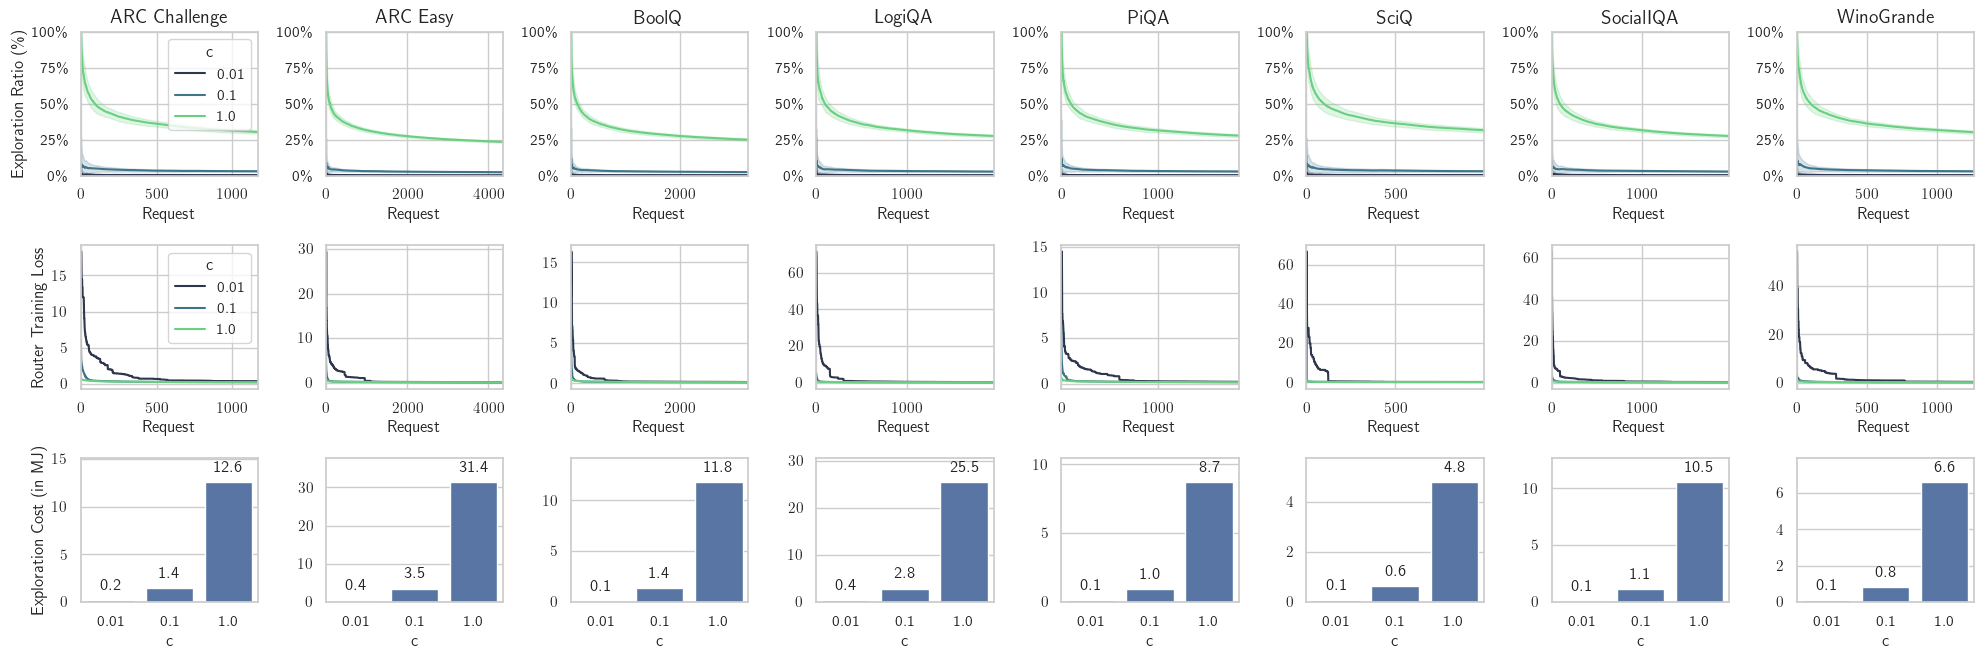

In [152]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=8, figsize=(20, 6.75))

BENCHMARK_NAME_DICT = {
    "arc_challenge": "ARC Challenge",
    "arc_easy": "ARC Easy",
    "boolq": "BoolQ",
    # "lambada_standard": "Lambada",
    "logiqa": "LogiQA",
    # "logiqa2": "LogiQA2",
    "piqa": "PiQA",
    "sciq": "SciQ",
    "social_iqa": "SocialIQA",
    "winogrande": "WinoGrande",
}

iterator = 0
for name, display_name in BENCHMARK_NAME_DICT.items():

	plt_data = run_df.loc[(run_df["benchmark_name"] == name), ["c", "mess_plus/energy", "classifier/train_loss", "_step", "mess_plus/exploration_step_ratio", "mess_plus/p_t"]]

	plt_data["exploration_cost"] = plt_data["mess_plus/energy"] * plt_data["mess_plus/p_t"]

	sns.lineplot(
	    data=plt_data[["_step", "mess_plus/exploration_step_ratio", "c"]],
	    x="_step",
	    y="mess_plus/exploration_step_ratio",
	    hue="c",
		errorbar=("sd", 1),
		ax=axes[0][iterator],
		legend=True if iterator == 0 else False,
		palette=["#2f364d", "#3f758a", "#69cf81"]
	)

	plt_data.loc[plt_data["c"] == 0.1, "classifier/train_loss"] /= 0.1
	plt_data.loc[plt_data["c"] == 0.01, "classifier/train_loss"] /= 0.01

	sns.lineplot(
	    data=plt_data[["_step", "classifier/train_loss", "c"]],
	    x="_step",
	    y="classifier/train_loss",
	    hue="c",
		errorbar=None, # ("sd", 1),
		ax=axes[1][iterator],
		legend=True if iterator == 0 else False,
		palette=["#2f364d", "#3f758a", "#69cf81"]
	)

	# bar_data = plt_data[["_step", "mess_plus/energy", "c"]].groupby(["c"], as_index=False).sum()
	plt_data["exploration_cost"] = plt_data["exploration_cost"] / 1_000_000 # convert to MJ
	sns.barplot(
	    data=plt_data,
	    x="c",
	    y="exploration_cost",
		errorbar=("sd", 1),
		ax=axes[2][iterator],
		legend=False,
		estimator=np.sum
	)

	axes[0][iterator].set_xlim([0, plt_data["_step"].max()])
	axes[0][iterator].set_ylim([0, 1])
	axes[0][iterator].set_xlabel("Request")
	axes[1][iterator].set_xlabel("Request")
	axes[0][iterator].set_title(display_name, fontsize=14)
	axes[0][iterator].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

	# axes[1][iterator].set_ylim([0, 2])
	axes[1][iterator].set_xlim([0, plt_data["_step"].max()])

	axes[2][iterator].set_ylim([0, 1.2 * plt_data.groupby("c")["exploration_cost"].sum().max()])
	add_value_labels(axes[2][iterator], convert_to_mj=False)

	if iterator == 0:
		axes[0][iterator].set_ylabel("Exploration Ratio (\%)")
		axes[1][iterator].set_ylabel("Router Training Loss")
		axes[2][iterator].set_ylabel("Exploration Cost (in MJ)")
		axes[0][iterator].legend(title="c")
	else:
		axes[0][iterator].set_ylabel(None)
		axes[1][iterator].set_ylabel(None)
		axes[2][iterator].set_ylabel(None)

	iterator += 1

plt.tight_layout()
write_figure_to_disk(plt, file_name="c_ablation_study", chapter_name="evaluations")